## CounteRGAN on the MNIST dataset

In [1]:
import tensorflow as tf
tf.__version__

'2.17.0'

In [12]:
BASE_PATH = r"D:\PycharmProjects\XAIRobustness\experiments\test"

LOAD_AUTOENCODER_AND_CLASSIFIER = False

## Imports and configuration

In [13]:
import os
import numpy as np
import json
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt

os.makedirs(BASE_PATH, exist_ok=True)

date = datetime.now().strftime('%Y-%m-%d')
EXPERIMENT_PATH = f"{BASE_PATH}/mnist_{date}"  # Where to store the experiment results
os.makedirs(EXPERIMENT_PATH, exist_ok=True)
# Change to your directory
MODELS_EXPERIMENT_PATH = r'D:\PycharmProjects\XAIRobustness\CARLA_VISUAL\carla_visual\recourse_methods\countergan\models_tf_weights'  # Where the models are stored
DESIRED_CLASS = 8

In [14]:
def plot_generated_images(x, n_plots=5, n_plots_per_row=5, residuals=False):
    """Plot several images in a grid."""
    x = x.reshape((x.shape[0], 28, 28))
    lower_bound = -1 if residuals else 0
    upper_bound = 1
    for i in range(n_plots):
        ax = plt.subplot(5, n_plots_per_row, 1 + i)
        ax.axis('off')
        ax.imshow(x[i], vmin=lower_bound, vmax=upper_bound, cmap="gray")
    plt.show()

def compute_reconstruction_error(x, autoencoder):
    """Compute the reconstruction error for a given autoencoder and data points."""
    preds = autoencoder.predict(x)
    preds_flat = preds.reshape((preds.shape[0], -1))
    x_flat = x.reshape((x.shape[0], -1))
    return np.linalg.norm(x_flat - preds_flat, axis=1)

def format_metric(metric):
    """Return a formatted version of a metric, with the confidence interval."""
    return f"{metric.mean():.3f} ± {1.96*metric.std()/np.sqrt(len(metric)):.3f}"

def compute_metrics(samples, counterfactuals, latencies, classifier, autoencoder,
                    batch_latency=None):
    """ Summarize the relevant metrics in a dictionary. """
    reconstruction_error = compute_reconstruction_error(counterfactuals, autoencoder)

    delta = np.abs(samples-counterfactuals)
    l1_distances = delta.reshape(delta.shape[0], -1).sum(axis=1)

    prediction_gain = (
        classifier.predict(counterfactuals)[:, DESIRED_CLASS] -
        classifier.predict(samples)[:, DESIRED_CLASS]
    )

    metrics = dict()
    metrics["reconstruction_error"] = format_metric(reconstruction_error)
    metrics["prediction_gain"] = format_metric(prediction_gain)
    metrics["sparsity"] = format_metric(l1_distances)
    metrics["latency"] = format_metric(latencies)
    batch_latency = batch_latency if batch_latency else sum(latencies)
    metrics["latency_batch"] = f"{batch_latency:.3f}"

    return metrics


def save_experiment(method_name, samples, counterfactuals, latencies,
                    batch_latency=None):
    """Create an experiment folder and save counterfactuals, latencies and metrics."""
    if not os.path.exists(f"{EXPERIMENT_PATH}/{method_name}"):
        os.makedirs(f"{EXPERIMENT_PATH}/{method_name}")

    np.save(f"{EXPERIMENT_PATH}/{method_name}/counterfactuals.npy", counterfactuals)
    np.save(f"{EXPERIMENT_PATH}/{method_name}/latencies.npy", latencies)

    metrics = compute_metrics(samples, counterfactuals, latencies, classifier, autoencoder)
    json.dump(metrics, open(f"{EXPERIMENT_PATH}/{method_name}/metrics.json", "w"))
    pprint(metrics)

## Data loading and preprocessing

In [15]:
import json
import pickle
import time
from matplotlib import offsetbox
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, UpSampling2D, \
    Flatten, LeakyReLU, BatchNormalization, GaussianNoise, Reshape, Conv2DTranspose, \
    Input, Add, Subtract, ActivityRegularization
from tensorflow.keras import Model, optimizers, regularizers

plt.rcParams['figure.figsize'] = [13, 5]

(x_train, y_train), (x_test, y_test) = load_data()

x_train = (x_train / 255.).astype("float32")
x_test = (x_test / 255.).astype("float32")

DESIRED_CLASS = 9  # This is the target class that the generator will learn to synthetize
N_CLASSES = 10

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_flat = x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2]))

X_train = np.expand_dims(x_train, axis=-1)
X_test = np.expand_dims(x_test, axis=-1)


if LOAD_AUTOENCODER_AND_CLASSIFIER:
    classifier = load_model(f"{MODELS_EXPERIMENT_PATH}/classifier.h5")
    y_prob = classifier.predict(X_test)
    accuracy = (y_prob.argmax(axis=1) == y_test.argmax(axis=1)).mean()
    print(f"Classifier accuracy test: {accuracy:.3f}")

    autoencoder = load_model(f"{MODELS_EXPERIMENT_PATH}/autoencoder.h5")
    reconstruction_error_test = compute_reconstruction_error(X_test, autoencoder)
    print(f"AE average reconstruction error: {reconstruction_error_test.mean():.3f}")

## Classifier training

In [16]:
tf.random.set_seed(2020)
np.random.seed(2020)

def create_classifier(input_shape=(28, 28, 1)):
    model = Sequential([
        Conv2D(filters=64, kernel_size=2, padding='same', activation='relu',
               input_shape=input_shape),
        MaxPooling2D(pool_size=2),
        Dropout(0.3),
        Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
        MaxPooling2D(pool_size=2),
        Dropout(0.3),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax'),
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

if not LOAD_AUTOENCODER_AND_CLASSIFIER:
    classifier = create_classifier()

    training = classifier.fit(
        np.expand_dims(x_train, axis=-1), y_train, batch_size=64, epochs=5,
        validation_data=(np.expand_dims(x_test, axis=-1), y_test), verbose=0
    )
    print(f"Training: loss={training.history['loss'][-1]:.4f}, "
        f"accuracy={training.history['accuracy'][-1]:.4f}")
    print(f"Validation: loss={training.history['val_loss'][-1]:.4f}, "
        f"accuracy={training.history['val_accuracy'][-1]:.4f}")

    classifier.save(f"{EXPERIMENT_PATH}/classifier.h5")

d:\PycharmProjects\XAIRobustness\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training: loss=0.0726, accuracy=0.9776
Validation: loss=0.0330, accuracy=0.9901


## Estimate density with the reconstruction error of a (denoising) autoencoder

In [17]:
def add_noise(x, noise_factor=0.5):
    noise_factor = 0.5
    x_noisy = x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    x_noisy = np.clip(x_noisy, 0., 1.)
    return x_noisy

def create_convolutional_autoencoder(in_shape=(28, 28, 1)):
    input_img = Input(shape=in_shape)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='linear', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    optimizer = optimizers.Nadam()
    autoencoder.compile(optimizer, 'mse')
    return autoencoder

if not LOAD_AUTOENCODER_AND_CLASSIFIER:
    autoencoder = create_convolutional_autoencoder()
    training = autoencoder.fit(
        add_noise(X_train), X_train, epochs=5, batch_size=32, shuffle=True,
        verbose=0, validation_data=(X_test, X_test)
    )
    print(f"Training loss: {training.history['loss'][-1]:.4f}")
    print(f"Validation loss: {training.history['val_loss'][-1]:.4f}")

    # Compute the reconstruction error of noise data
    samples = np.random.uniform(low=0.0, high=1.0, size=(1000, 28, 28, 1))
    reconstruction_error_noise = compute_reconstruction_error(samples, autoencoder)

    # Save and print the autoencoder metrics
    reconstruction_error = compute_reconstruction_error(X_test, autoencoder)
    autoencoder_metrics = {
        "reconstruction_error": format_metric(reconstruction_error),
        "reconstruction_error_noise": format_metric(reconstruction_error_noise),
    }
    json.dump(autoencoder_metrics,
              open(f"{EXPERIMENT_PATH}/autoencoder_metrics.json", "w"))
    pprint(autoencoder_metrics)

    autoencoder.save(f"{EXPERIMENT_PATH}/autoencoder.h5")

Training loss: 0.0219
Validation loss: 0.0169
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


{'reconstruction_error': '3.553 ± 0.016',
 'reconstruction_error_noise': '11.982 ± 0.015'}


## Counterfactuals search with Regularized Gradient Descent (RGD)


In [ ]:
from alibi.explainers import CounterFactual

shape = (1,) + X_train.shape[1:]
feature_range = (X_train.min(), X_train.max())

cf = CounterFactual(
    classifier, shape=shape, target_proba=1.0, tol=0.5, target_class=DESIRED_CLASS,
    max_iter=200, lam_init=1., max_lam_steps=5, learning_rate_init=0.1,
    feature_range=feature_range
)

### Example of counterfactual search with RGD

Counterfactual prediction: 8 with probability 0.998
CPU times: user 3.35 s, sys: 288 ms, total: 3.64 s
Wall time: 2.83 s


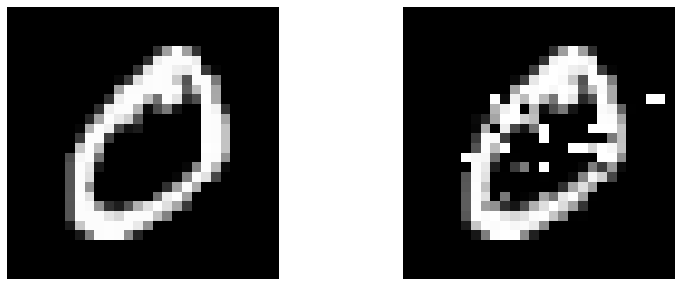

In [ ]:
%%time
sample = X_train[1]
explanation = cf.explain(np.expand_dims(sample, axis=0))

pred_class = explanation.cf['class']
proba = explanation.cf['proba'][0][pred_class]
print(f'Counterfactual prediction: {pred_class} with probability {proba:.3f}')

f, axes = plt.subplots(1, 2)
axes[0].axis('off')
axes[0].imshow(sample.reshape((28, 28)), cmap="gray")
axes[1].axis('off')
axes[1].imshow(explanation.cf['X'].reshape((28, 28)), cmap="gray")
f.show()

### Full experiment: counterfactual search on the entire test set

In [ ]:
samples = X_test[:5]  # Remove indexing for the full experiment

latencies = np.empty(len(samples))
counterfactuals = np.empty_like(samples)

for i, sample in enumerate(samples):
    if ((i % 100) == 0) or (i == (len(samples)-1)):
        print(f"{i+1}-th iteration at {datetime.now()}")
    t_initial = time.time()
    try:
        explanation = cf.explain(np.expand_dims(sample, axis=0))
        counterfactuals[i] = explanation.cf['X']
    except (UnboundLocalError, TypeError):  # counterfactual search failed
        print(f"{i}-th sampled failed")
        counterfactuals[i] = sample
    latencies[i] = 1000*(time.time() - t_initial)

save_experiment("rgd", samples, counterfactuals, latencies)

1-th iteration at 2020-09-17 01:02:01.053152
5-th iteration at 2020-09-17 01:02:11.294171
{'latency': '2.565 ± 0.063',
 'latency_batch': '12.83',
 'prediction_gain': '0.997 ± 0.003',
 'reconstruction_error': '4.953 ± 0.751',
 'sparsity': '21.664 ± 5.088'}


## Prototype-guided counterfactuals

In [ ]:
def create_prototype_autoencoder(input_shape=(28, 28, 1)):
    """Define an autoencoder to guide the counterfactual search with prototypes
    defined in the autoencoder latent space."""
    # encoder
    x_in = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    encoder = Model(x_in, encoded)

    # decoder
    dec_in = Input(shape=(14, 14, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(dec_in)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    decoder = Model(dec_in, decoded)

    # autoencoder = encoder + decoder
    x_out = decoder(encoder(x_in))
    autoencoder = Model(x_in, x_out)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder, decoder

prototype_autoencoder, prototype_encoder, _ = create_prototype_autoencoder()
training = prototype_autoencoder.fit(X_train, X_train, batch_size=128, epochs=4,
                                     validation_data=(X_test, X_test), verbose=0)

print(f"Training loss: {training.history['loss'][-1]:.4f}")
print(f"Validation loss: {training.history['val_loss'][-1]:.4f}")

if not os.path.exists(f"{EXPERIMENT_PATH}/csgp"):
    os.makedirs(f"{EXPERIMENT_PATH}/csgp")

prototype_autoencoder.save(f"{EXPERIMENT_PATH}/csgp/mnist_autoencoder.h5")
prototype_encoder.save(f"{EXPERIMENT_PATH}/csgp/mnist_encoder.h5")

In [ ]:
from alibi.explainers import CounterFactualProto

shape = (1,) + X_train.shape[1:]
feature_range = (X_train.min(), X_train.max())

cf_proto = CounterFactualProto(
    classifier, shape, kappa=0., beta=.01, gamma=100., theta=100., ae_model=None,
    enc_model=prototype_encoder, max_iterations=200, feature_range=feature_range,
    c_init=1., c_steps=5, learning_rate_init=1e-2, clip=(-1000., 1000.),)
cf_proto.fit(X_train);

### Example of counterfactual search with CSGP

Counterfactual prediction: 8 with probability 0.635
CPU times: user 7.61 s, sys: 725 ms, total: 8.33 s
Wall time: 5.9 s


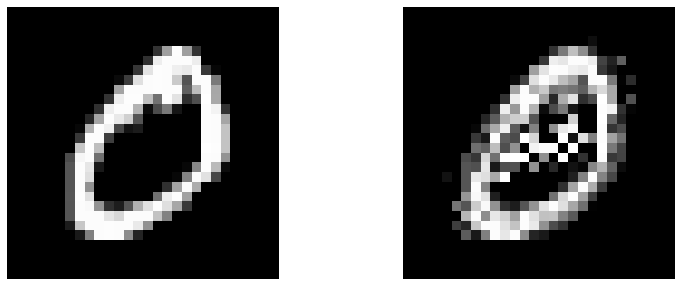

In [ ]:
%%time
sample = X_train[1]
explanation = cf_proto.explain(np.expand_dims(sample, axis=0), k=20, k_type='mean',
                               target_class=[DESIRED_CLASS])

pred_class = explanation.cf['class']
proba = explanation.cf['proba'][0][pred_class]
print(f'Counterfactual prediction: {pred_class} with probability {proba:.3f}')

f, axes = plt.subplots(1, 2)
axes[0].axis('off')
axes[0].imshow(sample.reshape((28, 28)), cmap="gray")
axes[1].axis('off')
axes[1].imshow(explanation.cf['X'].reshape((28, 28)), cmap="gray")
f.show()

### Full experiment: counterfactual search on the entire test set

In [ ]:
samples = X_test[:5]  # Remove indexing for the full experiment

latencies = np.empty(len(samples))
counterfactuals = np.empty_like(samples)
for i, sample in enumerate(samples):
    if ((i % 100) == 0) or (i == (len(samples)-1)):
        print(f"{i+1}-th iteration at {datetime.now()}")
    t_initial = time.time()
    try:
        explanation = cf_proto.explain(np.expand_dims(sample, axis=0), k=20,
                                       k_type='mean', target_class=[DESIRED_CLASS])
        counterfactuals[i] = explanation.cf['X']
    except (UnboundLocalError, TypeError) as e:  # counterfactual search failed
        print(f"{i}-th sampled failed")
        counterfactuals[i] = sample
    latencies[i] = 1000*(time.time() - t_initial)

save_experiment("csgp", samples, counterfactuals, latencies)

1-th iteration at 2020-09-17 01:03:46.890669
5-th iteration at 2020-09-17 01:04:08.768653
{'latency': '5.454 ± 0.037',
 'latency_batch': '27.27',
 'prediction_gain': '0.394 ± 0.082',
 'reconstruction_error': '4.452 ± 0.384',
 'sparsity': '47.565 ± 10.739'}


## GAN-based counterfactual search

In [18]:
def generate_fake_samples(x, generator):
    """Use the input generator to generate samples."""
    return generator.predict(x)

def data_stream(x, y=None, batch_size=500):
    """Generate batches until exhaustion of the input data."""
    n_train = x.shape[0]
    if y is not None:
        assert n_train == len(y)
    n_complete_batches, leftover = divmod(n_train, batch_size)
    n_batches = n_complete_batches + bool(leftover)

    perm = np.random.permutation(n_train)
    for i in range(n_batches):
        batch_idx = perm[i * batch_size:(i + 1) * batch_size]
        if y is not None:
            output = (x[batch_idx], y[batch_idx])
        else:
            output = x[batch_idx]
        yield output


def infinite_data_stream(x, y=None, batch_size=500):
    """Infinite batch generator."""
    batches = data_stream(x, y, batch_size=batch_size)
    while True:
        try:
            yield next(batches)
        except StopIteration:
            batches = data_stream(x, y, batch_size=batch_size)
            yield next(batches)


def create_generator(in_shape=(28, 28, 1), residuals=True):
    """Define and compile the residual generator of the CounteRGAN."""
    generator_input = Input(shape=in_shape, name='generator_input')
    generator = Conv2D(64, (3,3), strides=(2, 2), padding='same')(generator_input)
    generator = LeakyReLU(alpha=0.2)(generator)
    generator = Dropout(0.2)(generator)
    generator = Conv2D(64, (3,3), strides=(2, 2), padding='same')(generator)
    generator = LeakyReLU(alpha=0.2)(generator)
    generator = Dropout(0.2)(generator)
    generator = Flatten()(generator)

    # Deconvolution
    n_nodes = 128 * 7 * 7 # foundation for 7x7 image
    generator = Dense(n_nodes)(generator)
    generator = LeakyReLU(alpha=0.2)(generator)
    generator = Reshape((7, 7, 128))(generator)
    # upsample to 14x14
    generator = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')(generator)
    # upsample to 28x28
    generator = LeakyReLU(alpha=0.2)(generator)

    generator = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')(generator)
    generator = LeakyReLU(alpha=0.2)(generator)

    generator = Conv2D(1, (7,7), activation='tanh', padding='same')(generator)
    generator = Reshape((28, 28, 1))(generator)
    # these are residuals

    generator_output = ActivityRegularization(l1=1e-5, l2=0.0)(generator)
    print(generator)
    print(generator_output)

    if residuals:
        generator_output = Add(name="output")([generator_input, generator_output])

    return Model(inputs=generator_input, outputs=generator_output)

def create_discriminator(in_shape=(28, 28, 1)):
    """ Define a neural network binary classifier to classify real and generated
    examples."""
    model = Sequential([
        Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape),
        GaussianNoise(0.2),
        LeakyReLU(alpha=0.2),
        Dropout(0.4),
        Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.4),
        Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.4),
        Flatten(),
        Dense(1, activation='sigmoid'),
    ], name="discriminator")
    optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


def define_countergan(generator, discriminator, classifier, input_shape=(28, 28, 1)):
    """Combine a generator, discriminator, and fixed classifier into the CounteRGAN."""
    discriminator.trainable = False
    classifier.trainable = False

    countergan_input = Input(shape=input_shape, name='countergan_input')

    x_generated = generator(countergan_input)

    countergan = Model(
        inputs=countergan_input,
        outputs=[discriminator(x_generated), classifier(x_generated)]
    )

    optimizer = optimizers.RMSprop(learning_rate=4e-4, decay=1e-8)  # Generator optimizer
    countergan.compile(optimizer, loss=["binary_crossentropy", "categorical_crossentropy"])
    return countergan


def define_weighted_countergan(generator, discriminator, input_shape=(28, 28, 1)):
    """Combine a generator and a discriminator for the weighted version of the
    CounteRGAN."""
    discriminator.trainable = False
    classifier.trainable = False
    countergan_input = Input(shape=input_shape, name='countergan_input')

    x_generated = generator(countergan_input)

    countergan = Model(inputs=countergan_input, outputs=discriminator(x_generated))
    optimizer = optimizers.Nadam(learning_rate=5e-4, beta_1=0.5)
    countergan.compile(optimizer, "binary_crossentropy")
    return countergan

In [19]:
def train_countergan(n_discriminator_steps, n_generator_steps, n_training_iterations,
                     classifier, discriminator, generator, batches,
                     weighted_version=False, negative_batches=None, positive_batches=None,
                     ):
    """ Main function: train the CounteRGAN"""
    def check_divergence(x_generated):
        return np.all(np.isnan(x_generated))

    def print_training_information(generator, classifier, X_test, iteration):
        X_gen = generator.predict(X_test)
        clf_pred_test = classifier.predict(X_test) # y_M
        clf_pred = classifier.predict(X_gen)  # y_cf

        delta_clf_pred = (clf_pred - clf_pred_test)[:, DESIRED_CLASS]
        y_target = to_categorical([DESIRED_CLASS] * len(clf_pred), num_classes=N_CLASSES)
        print('='*88)
        print(f"Training iteration {iteration} at {datetime.now()}")

        # Plot original images, residuals, and generated images
        sample_indices  = np.random.choice(len(X_test), 10, replace=False)
        residuals = X_gen[sample_indices]-X_test[sample_indices]

        plot_generated_images(X_test[sample_indices], n_plots=10, n_plots_per_row=10)
        plot_generated_images(residuals, n_plots=10, n_plots_per_row=10, residuals=True)
        plot_generated_images(X_gen[sample_indices], n_plots=10, n_plots_per_row=10)

        reconstruction_error = np.mean(compute_reconstruction_error(X_gen, autoencoder))
        print(f"Autoencoder reconstruction error (infinity to 0): {reconstruction_error:.3f}")
        print(f"Counterfactual prediction gain (0 to 1): {delta_clf_pred.mean():.3f}")
        print(f"Sparsity (L1, infinity to 0): {np.mean(np.abs(X_gen-X_test)):.3f}")

    if weighted_version:
        countergan = define_weighted_countergan(generator, discriminator)
    else:
        countergan = define_countergan(generator, discriminator, classifier)

    for iteration in range(n_training_iterations):
        if iteration > 0:
            x_generated = generator.predict(x_fake_input)
            if check_divergence(x_generated):
                print("Training diverged with the following loss functions:")
                print(discrim_loss_1, discrim_accuracy, gan_loss,
                    discrim_loss, discrim_loss_2, clf_loss)
                break

        # Periodically print and plot training information
        if (iteration % 1000 == 0) or (iteration == n_training_iterations - 1):
            print_training_information(generator, classifier, X_test, iteration)

        # Train the discriminator
        discriminator.trainable = True
        for _ in range(n_discriminator_steps):
            # if weighted_version:
            #     x_fake_input, _ = next(negative_batches)
            #     x_real, _ = next(positive_batches)
            # else:
            x_fake_input, _ = next(batches)
            x_real = x_fake_input

            x_fake = generate_fake_samples(x_fake_input, generator)

            x_batch = np.concatenate([x_real, x_fake])
            y_batch = np.concatenate([np.ones(len(x_real)), np.zeros(len(x_fake))])

            # Shuffle real and fake examples
            p = np.random.permutation(len(y_batch))
            x_batch, y_batch = x_batch[p], y_batch[p]

            if weighted_version:
                classifier_scores = classifier.predict(x_batch)[:, DESIRED_CLASS]

                # The following update to the classifier scores is needed to have the
                # same order of magnitude between real and generated samples losses
                real_samples = np.where(y_batch == 1.)
                average_score_real_samples = np.mean(classifier_scores[real_samples])
                classifier_scores[real_samples] /= average_score_real_samples

                fake_samples = np.where(y_batch == 0.)
                classifier_scores[fake_samples] = 1.

                discriminator.train_on_batch(
                    x_batch, y_batch, sample_weight=classifier_scores
                )
            else:
                discriminator.train_on_batch(x_batch, y_batch)

        # Train the generator
        discriminator.trainable = False
        for _ in range(n_generator_steps):
            x_fake_input, _ = next(batches)
            y_fake = np.ones(len(x_fake_input))
            if weighted_version:
                countergan.train_on_batch(x_fake_input, y_fake)
            else:
                y_target = to_categorical([DESIRED_CLASS] * len(x_fake_input),
                                          num_classes=N_CLASSES)
                countergan.train_on_batch(x_fake_input, [y_fake, y_target])
    return countergan

## Counterfactual search with a regular GAN

In [20]:
discriminator = create_discriminator()
generator = create_generator(residuals=False)
batches = infinite_data_stream(X_train, y_train, batch_size=256)


<KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=False, name=keras_tensor_146>
<KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=False, name=keras_tensor_147>


d:\PycharmProjects\XAIRobustness\venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


  5/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step 

d:\PycharmProjects\XAIRobustness\venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training iteration 0 at 2024-10-11 10:55:28.822245


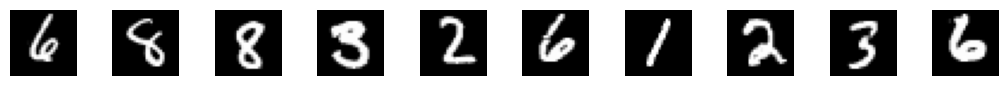

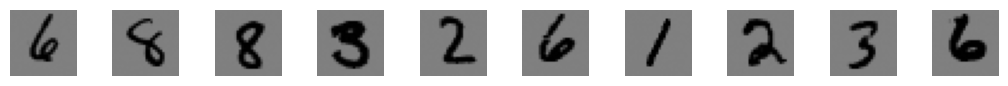

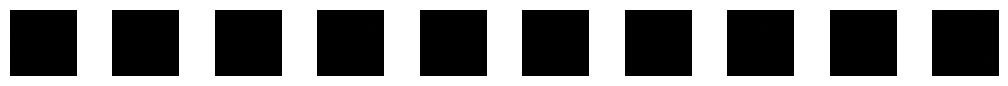

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Autoencoder reconstruction error (infinity to 0): 0.204
Counterfactual prediction gain (0 to 1): -0.015
Sparsity (L1, infinity to 0): 0.135
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


AttributeError: 'NoneType' object has no attribute 'update_state'

In [22]:
method_name = "regular_gan"
countergan = train_countergan(2, 3, 10000, classifier, discriminator, generator, batches)

t_initial = time.time()
counterfactuals = generator.predict(X_test)
batch_latency = 1000*(time.time() - t_initial)

latencies = np.zeros(len(X_test))
for i, x in enumerate(X_test):
    t_initial = time.time()
    _ = generator.predict(np.expand_dims(x, axis=0))
    latencies[i] = 1000*(time.time() - t_initial)

save_experiment(method_name, X_test, counterfactuals, latencies, batch_latency)

generator.save(f"{EXPERIMENT_PATH}/{method_name}/generator.h5", save_format='h5')
discriminator.save(f"{EXPERIMENT_PATH}/{method_name}/discriminator.h5", save_format='h5')
countergan.save(f"{EXPERIMENT_PATH}/{method_name}/countergan.h5", save_format='h5')

## CounteRGAN: first formulation for differentiable classifiers

<KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=False, name=keras_tensor_179>
<KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=False, name=keras_tensor_180>
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training iteration 0 at 2024-10-11 10:55:40.035466


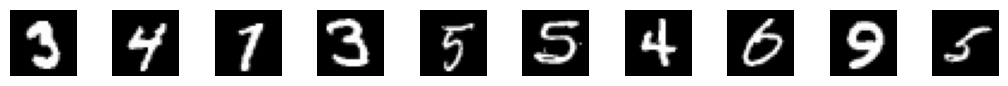

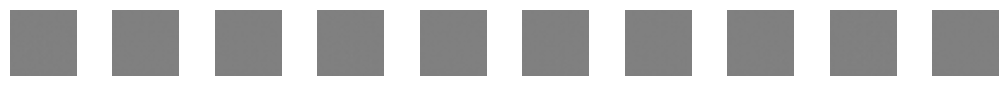

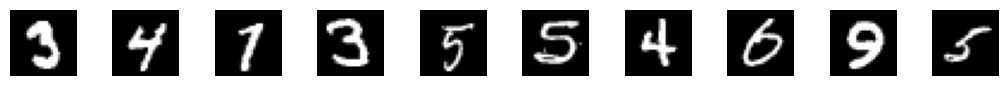

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Autoencoder reconstruction error (infinity to 0): 3.555
Counterfactual prediction gain (0 to 1): -0.000
Sparsity (L1, infinity to 0): 0.003
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


AttributeError: 'NoneType' object has no attribute 'update_state'

In [23]:
discriminator = create_discriminator()
generator = create_generator(residuals=True)
batches = infinite_data_stream(X_train, y_train, batch_size=256)

method_name = "countergan"
countergan = train_countergan(2, 3, 10000, classifier, discriminator, generator, batches)

t_initial = time.time()
counterfactuals = generator.predict(X_test)
batch_latency = 1000*(time.time() - t_initial)

latencies = np.zeros(len(X_test))
for i, x in enumerate(X_test):
    t_initial = time.time()
    _ = generator.predict(np.expand_dims(x, axis=0))
    latencies[i] = 1000*(time.time() - t_initial)


save_experiment(method_name, X_test, counterfactuals, latencies, batch_latency)
generator.save(f"{EXPERIMENT_PATH}/{method_name}/generator_9.h5")
discriminator.save(f"{EXPERIMENT_PATH}/{method_name}/discriminator_9.h5")
countergan.save(f"{EXPERIMENT_PATH}/{method_name}/countergan_9.h5")

## CounteRGAN: second formulation for any classifier

Training iteration 0 at 2020-09-17 22:56:46.888487


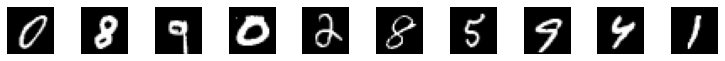

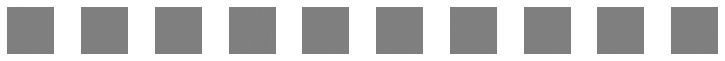

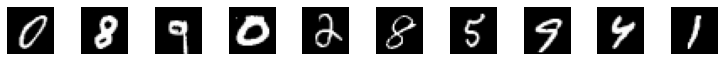

Autoencoder reconstruction error (infinity to 0): 3.701
Counterfactual prediction gain (0 to 1): -0.000
Sparsity (L1, infinity to 0): 0.003
Training iteration 1000 at 2020-09-17 23:00:46.201462


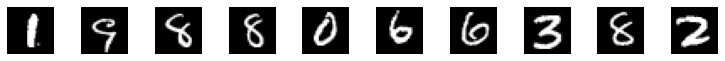

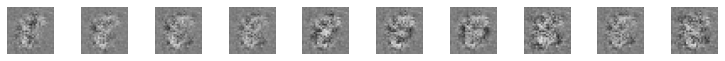

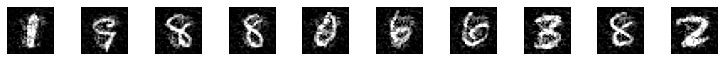

Autoencoder reconstruction error (infinity to 0): 5.821
Counterfactual prediction gain (0 to 1): 0.295
Sparsity (L1, infinity to 0): 0.126
Training iteration 2000 at 2020-09-17 23:04:43.171268


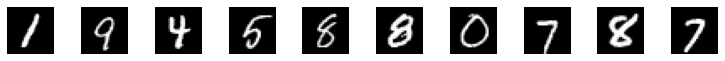

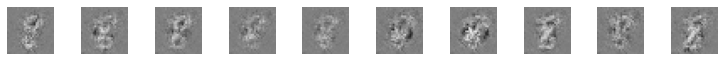

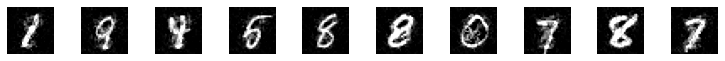

Autoencoder reconstruction error (infinity to 0): 5.113
Counterfactual prediction gain (0 to 1): 0.256
Sparsity (L1, infinity to 0): 0.099
Training iteration 3000 at 2020-09-17 23:08:39.925026


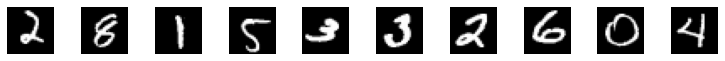

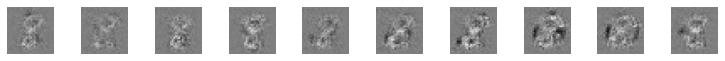

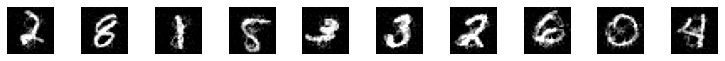

Autoencoder reconstruction error (infinity to 0): 4.866
Counterfactual prediction gain (0 to 1): 0.095
Sparsity (L1, infinity to 0): 0.085
Training iteration 4000 at 2020-09-17 23:12:36.591432


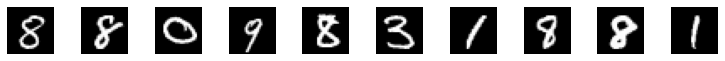

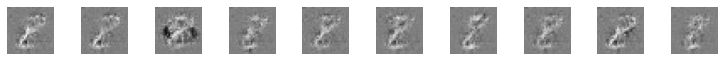

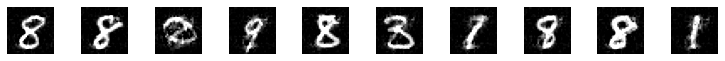

Autoencoder reconstruction error (infinity to 0): 5.304
Counterfactual prediction gain (0 to 1): 0.228
Sparsity (L1, infinity to 0): 0.102
Training iteration 5000 at 2020-09-17 23:16:32.544483


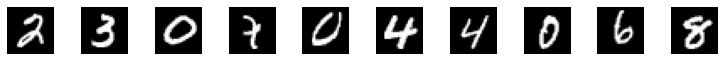

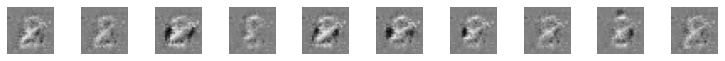

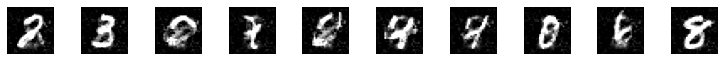

Autoencoder reconstruction error (infinity to 0): 5.013
Counterfactual prediction gain (0 to 1): 0.197
Sparsity (L1, infinity to 0): 0.101
Training iteration 6000 at 2020-09-17 23:20:28.708118


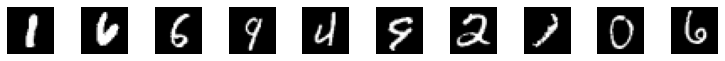

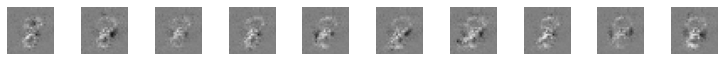

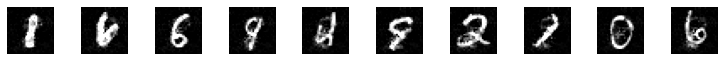

Autoencoder reconstruction error (infinity to 0): 4.683
Counterfactual prediction gain (0 to 1): 0.097
Sparsity (L1, infinity to 0): 0.071
Training iteration 7000 at 2020-09-17 23:24:24.593770


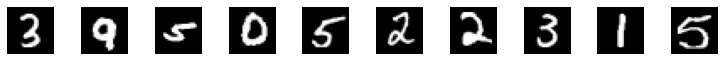

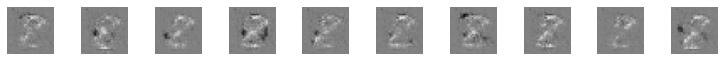

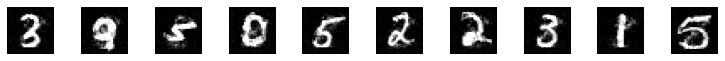

Autoencoder reconstruction error (infinity to 0): 4.443
Counterfactual prediction gain (0 to 1): 0.036
Sparsity (L1, infinity to 0): 0.062


In [ ]:
discriminator = create_discriminator()
generator = create_generator(residuals=True)

batches = infinite_data_stream(X_train, y_train, batch_size=256)
y_neg = np.where(y_train[:, 1] == 0)
y_pos = np.where(y_train[:, 1] == 1)
negative_batches = infinite_data_stream(X_train[y_neg], y_train[y_neg], batch_size=256)
positive_batches = infinite_data_stream(X_train[y_pos], y_train[y_pos], batch_size=256)

method_name = "countergan-wt"
countergan = train_countergan(
    1, 2, 20000, classifier, discriminator, generator, batches, True, )
    # negative_batches, positive_batches)

t_initial = time.time()
counterfactuals = generator.predict(X_test)
batch_latency = 1000*(time.time() - t_initial)

latencies = np.zeros(len(X_test))
for i, x in enumerate(X_test):
    t_initial = time.time()
    _ = countergan.predict(np.expand_dims(x, axis=0))
    latencies[i] = 1000*(time.time() - t_initial)

save_experiment(method_name, X_test, counterfactuals, latencies, batch_latency)
generator.save(f"{EXPERIMENT_PATH}/{method_name}/generator.h5", save_format="h5")
discriminator.save(f"{EXPERIMENT_PATH}/{method_name}/discriminator.h5", save_format="h5")
countergan.save(f"{EXPERIMENT_PATH}/{method_name}/countergan.h5", save_format="h5")